In [2]:
import os
import re

import numpy as np
import pandas as pd
import pytorch_lightning as pl
import matplotlib.pyplot as plt
import seaborn as sns

pl.seed_everything(32)

Seed set to 32


In [3]:
adata_obs = pd.read_csv("/data/danai/Data/OneK1K/LogNorm_counts_across_celltypes_DCRM_protein-coding_Azimuth_only-immune-cells_HVG-HEX-10K_adata-obs.tsv", 
                       sep="\t", index_col=0)

adata_obs 

,orig_ident,nCount_RNA,nFeature_RNA,pool,individual,percent_mt,latent,nCount_SCT,nFeature_SCT,cell_type,...,n_genes,Norm_factors,major_celltype,predicted_celltype_l0,predicted_celltype_l1,predicted_celltype_l2,original_celltype,new_predicted_celltype_l2,new_predicted_celltype_l0,new_predicted_celltype_l1
barcode,,,,,,,,,,,,,,,,,,,,,
AAACCTGAGAATGTTG-1,0,4754.0,1201,0,691_692,1.451409,0,3226.0,1186,1,...,1201,4754.0,CD4T,T,CD4T,CD4 TEM,CD4+ KLRB1+ T cell,CD4 TCM,T,CD4T
AAACCTGAGAGAACAG-1,0,2459.0,896,0,693_694,3.700691,0,2710.0,896,14,...,896,2459.0,NK,T,NK,NK,XCL1- NK,NK,T,NK
AAACCTGAGCATGGCA-1,0,2451.0,674,0,688_689,3.386373,0,2759.0,674,0,...,674,2451.0,CD4T,T,CD4T,CD4 Naive,CD4+ KLRB1- T cell,CD4 Naive,T,CD4T
AAACCTGAGTATTGGA-1,0,8720.0,1784,0,683_684,2.626147,0,3226.0,1186,5,...,1784,8720.0,CD8T,T,CD8T,CD8 TEM,CD8+ S100B+ T cell,CD8 TCM,T,CD8T
AAACCTGAGTGTCCCG-1,0,3461.0,941,0,684_685,4.911875,0,3038.0,940,3,...,941,3461.0,CD8T,T,CD8T,CD8 TEM,CD8+ GNLY+ NKG7+ T cell,CD8 TEM,T,CD8T
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTCATCCGCTGTT-9,0,4201.0,1037,8,796_797,3.118305,0,3168.0,1035,13,...,1037,4201.0,B,B,B,B intermediate,TCL1A+ FCER2+ B cell,B intermediate,B,B
TTTGTCATCCGTTGTC-9,0,4797.0,985,8,800_801,2.147175,0,3174.0,973,0,...,985,4797.0,CD4T,T,CD4T,CD4 TCM,CD4+ KLRB1- T cell,CD4 TCM,T,CD4T
TTTGTCATCGCCGTGA-9,0,4494.0,895,8,821_822,2.314197,0,3116.0,881,0,...,895,4494.0,CD4T,T,CD4T,CD4 Naive,CD4+ KLRB1- T cell,CD4 Naive,T,CD4T


In [4]:
ckpt_dir = "/data/danai/Data/hydra_logs/LIVI2/trainable_A/runs"
testing_dir = "/data/danai/Data/OneK1K/LIVI2_testing_results"
figure_dir = os.path.join(testing_dir,
                          "2024-12-05_10-20_LIVIcis-cell-state_zdim15_700-gxc_5-persistent_60-0-warm-up_no-adversary_Gseed200_hvg-hex-10K_larger-encoder_best",
                          "Figures")


In [5]:
experiments_n_cells = [
    "2024-12-05_10-20_LIVIcis-cell-state_zdim15_700-gxc_5-persistent_60-0-warm-up_no-adversary_Gseed200_hvg-hex-10K_larger-encoder", # original dataset
    "LIVIcis-cell-state_zdim15_700-gxc_5-persistent_60-0-warm-up_no-adversary_Gseed200_hvg-hex-10K_Gseed200_700K-cells",
    "LIVIcis-cell-state_zdim15_700-gxc_5-persistent_60-0-warm-up_no-adversary_Gseed200_hvg-hex-10K_Gseed200_500K-cells",
    "LIVIcis-cell-state_zdim15_700-gxc_5-persistent_60-0-warm-up_no-adversary_Gseed200_hvg-hex-10K_Gseed200_300K-cells",
    "LIVIcis-cell-state_zdim15_700-gxc_5-persistent_60-0-warm-up_no-adversary_Gseed200_hvg-hex-10K_Gseed200_100K-cells",
    "LIVIcis-cell-state_zdim15_700-gxc_5-persistent_60-0-warm-up_no-adversary_Gseed200_hvg-hex-10K_Gseed200_1.5M-cells",
    "LIVIcis-cell-state_zdim15_700-gxc_5-persistent_60-0-warm-up_no-adversary_Gseed200_hvg-hex-10K_Gseed200_1.8M-cells",
    "LIVIcis-cell-state_zdim15_700-gxc_5-persistent_60-0-warm-up_no-adversary_Gseed200_hvg-hex-10K_Gseed200_2M-cells"
]

In [6]:
experiments_n_donors = [
    "2024-12-05_10-20_LIVIcis-cell-state_zdim15_700-gxc_5-persistent_60-0-warm-up_no-adversary_Gseed200_hvg-hex-10K_larger-encoder", # original dataset
    "LIVIcis-cell-state_zdim15_700-gxc_5-persistent_60-0-warm-up_no-adversary_Gseed200_hvg-hex-10K_Gseed200_1.5M-cells",
    "LIVIcis-cell-state_zdim15_700-gxc_5-persistent_60-0-warm-up_no-adversary_Gseed200_hvg-hex-10K_Gseed200_1.8M-cells",
    "LIVIcis-cell-state_zdim15_700-gxc_5-persistent_60-0-warm-up_no-adversary_Gseed200_hvg-hex-10K_Gseed200_2M-cells",
    "LIVIcis-cell-state_zdim15_700-gxc_5-persistent_60-0-warm-up_no-adversary_Gseed200_hvg-hex-10K_Gseed200_700-donors",
    "LIVIcis-cell-state_zdim15_700-gxc_5-persistent_60-0-warm-up_no-adversary_Gseed200_hvg-hex-10K_Gseed200_500-donors",
    "LIVIcis-cell-state_zdim15_700-gxc_5-persistent_60-0-warm-up_no-adversary_Gseed200_hvg-hex-10K_Gseed200_300-donors",
    "LIVIcis-cell-state_zdim15_700-gxc_5-persistent_60-0-warm-up_no-adversary_Gseed200_hvg-hex-10K_Gseed200_100-donors"
]

In [7]:
experiments_n_gxc = [
    "2024-12-05_10-20_LIVIcis-cell-state_zdim15_700-gxc_5-persistent_60-0-warm-up_no-adversary_Gseed200_hvg-hex-10K_larger-encoder", # original dataset
    "LIVIcis-cell-state_zdim15_900-gxc_5-persistent_60-0-warm-up_no-adversary_Gseed200_hvg-hex-10K_larger-encoder_Gseed200_best",
    "LIVIcis-cell-state_zdim15_500-gxc_5-persistent_60-0-warm-up_no-adversary_Gseed200_hvg-hex-10K_larger-encoder_best",
    "LIVIcis-cell-state_zdim15_300-gxc_5-persistent_60-0-warm-up_no-adversary_Gseed200_hvg-hex-10K_larger-encoder_Gseed200_best",
    "LIVIcis-cell-state_zdim15_100-gxc_5-persistent_60-0-warm-up_no-adversary_Gseed200_hvg-hex-10K_larger-encoder_Gseed200_best",
]

## Runtime

In [23]:
rt_seconds = {}

for exp in experiments_n_cells:
    ncells = exp.replace("LIVIcis-cell-state_zdim15_700-gxc_5-persistent_60-0-warm-up_no-adversary_Gseed200_hvg-hex-10K_Gseed200_", "")
    logs_exp = [di for di in os.listdir(ckpt_dir) if exp in di][0]
    rt = pd.read_csv(os.path.join(ckpt_dir, logs_exp, "exec_time.log"), sep=" ", header=None)
    rt = list(rt[3])[0] # runtime is in the 4th column
    rt_seconds[ncells] = rt

rt_seconds

{'2024-12-05_10-20_LIVIcis-cell-state_zdim15_700-gxc_5-persistent_60-0-warm-up_no-adversary_Gseed200_hvg-hex-10K_larger-encoder': 76473.67999529839,
 '700K-cells': 35209.15909051895,
 '500K-cells': 45953.23640537262,
 '300K-cells': 23096.20673418045,
 '100K-cells': 17078.23504972458,
 '1.5M-cells': 70509.924649477,
 '1.8M-cells': 79764.73420834541,
 '2M-cells': 95651.20874476431}

In [24]:
rt_hours = {k:v/3600 for k,v in rt_seconds.items()}
rt_hours

{'2024-12-05_10-20_LIVIcis-cell-state_zdim15_700-gxc_5-persistent_60-0-warm-up_no-adversary_Gseed200_hvg-hex-10K_larger-encoder': 21.242688887582887,
 '700K-cells': 9.780321969588597,
 '500K-cells': 12.764787890381283,
 '300K-cells': 6.415612981716792,
 '100K-cells': 4.74395418047905,
 '1.5M-cells': 19.58609018041028,
 '1.8M-cells': 22.15687061342928,
 '2M-cells': 26.569780206878978}

In [93]:
ncells = {
    "2024-12-05_10-20_LIVIcis-cell-state_zdim15_700-gxc_5-persistent_60-0-warm-up_no-adversary_Gseed200_hvg-hex-10K_larger-encoder": adata_obs.shape[0],
    "700K-cells": 7e5,
    "500K-cells": 5e5,
    "300K-cells": 3e5,
    "100K-cells": 1e5,
    "1.5M-cells": 1.5e6,
    "1.8M-cells": 1.8e6,
    "2M-cells": 2e6
}

In [30]:
rt_hours_plot = {ncells[k]: v for k,v in rt_hours.items()}
rt_hours_plot 

{1172790: 21.242688887582887,
 700000.0: 9.780321969588597,
 500000.0: 12.764787890381283,
 300000.0: 6.415612981716792,
 100000.0: 4.74395418047905,
 1500000.0: 19.58609018041028,
 1800000.0: 22.15687061342928,
 2000000.0: 26.569780206878978}

In [31]:
rt_seconds_donors = {}

for exp in experiments_n_donors:
    ndonors = exp.replace("LIVIcis-cell-state_zdim15_700-gxc_5-persistent_60-0-warm-up_no-adversary_Gseed200_hvg-hex-10K_Gseed200_", "")
    logs_exp = [di for di in os.listdir(ckpt_dir) if exp in di][0]
    rt = pd.read_csv(os.path.join(ckpt_dir, logs_exp, "exec_time.log"), sep=" ", header=None)
    rt = list(rt[3])[0] # runtime is in the 4th column
    rt_seconds_donors[ndonors] = rt

rt_seconds_donors

{'2024-12-05_10-20_LIVIcis-cell-state_zdim15_700-gxc_5-persistent_60-0-warm-up_no-adversary_Gseed200_hvg-hex-10K_larger-encoder': 76473.67999529839,
 '1.5M-cells': 70509.924649477,
 '1.8M-cells': 79764.73420834541,
 '2M-cells': 95651.20874476431,
 '700-donors': 44457.829738140106,
 '500-donors': 44147.80844497681,
 '300-donors': 16234.29453086853,
 '100-donors': 11542.197851657867}

In [32]:
rt_hours_donors = {k:v/3600 for k,v in rt_seconds_donors.items()}
rt_hours_donors

{'2024-12-05_10-20_LIVIcis-cell-state_zdim15_700-gxc_5-persistent_60-0-warm-up_no-adversary_Gseed200_hvg-hex-10K_larger-encoder': 21.242688887582887,
 '1.5M-cells': 19.58609018041028,
 '1.8M-cells': 22.15687061342928,
 '2M-cells': 26.569780206878978,
 '700-donors': 12.349397149483362,
 '500-donors': 12.263280123604668,
 '300-donors': 4.509526258574592,
 '100-donors': 3.2061660699049632}

In [36]:
ndonors = {
    "2024-12-05_10-20_LIVIcis-cell-state_zdim15_700-gxc_5-persistent_60-0-warm-up_no-adversary_Gseed200_hvg-hex-10K_larger-encoder": adata_obs.individual.nunique(),
    "700-donors": 700,
    "500-donors": 500,
    "300-donors": 300,
    "100-donors": 100,
    # "1.5M-cells": adata_obs.individual.nunique(),
    # "1.8M-cells": adata_obs.individual.nunique(),
    # "2M-cells": adata_obs.individual.nunique()
}

In [38]:
rt_hours_donors_plot = {ndonors[k]: v for k,v in rt_hours_donors.items() if k in list(ndonors.keys())}
rt_hours_donors_plot 

{981: 21.242688887582887,
 700: 12.349397149483362,
 500: 12.263280123604668,
 300: 4.509526258574592,
 100: 3.2061660699049632}

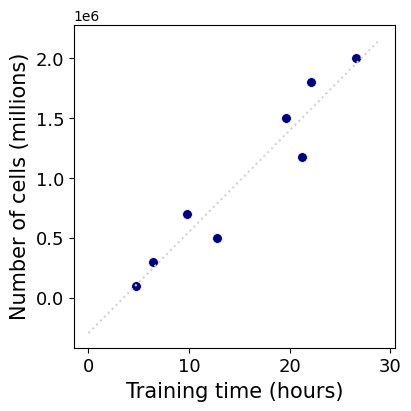

In [83]:
fig, axs = plt.subplots(nrows=1, figsize = (4,4), constrained_layout=True)
sns.scatterplot(x=[v for v in rt_hours_plot.values()], y=[k for k in rt_hours_plot.keys()], 
                ax=axs, color="navy", s=50, rasterized=True)
# axs.set_ylim(5e4, 2.5e6)
# axs.set_xlim(min([v for v in rt_hours_plot.values()])-5, max([v for v in rt_hours_plot.values()])+2)
x = np.arange(axs.get_xticks()[0], axs.get_xticks()[-1])
b, a = np.polyfit(x=[v for v in rt_hours_plot.values()], y=[k for k in rt_hours_plot.keys()], deg=1)
y = a +b *x
axs.plot(x, y, marker="", linestyle=":", color="lightgrey")
axs.tick_params(axis="both", labelsize=13)
axs.set_xlabel("Training time (hours)", fontdict={"fontsize":15})
axs.set_ylabel("Number of cells (millions)", fontdict={"fontsize":15})
# axs.set_xlim(2, 30)
plt.savefig(os.path.join(figure_dir, "Runtime_N_cells.png"), 
            transparent=True, dpi=300, bbox_inches="tight")
plt.savefig(os.path.join(figure_dir, "Runtime_N_cells.svg"), 
            transparent=True, dpi=300, bbox_inches="tight")

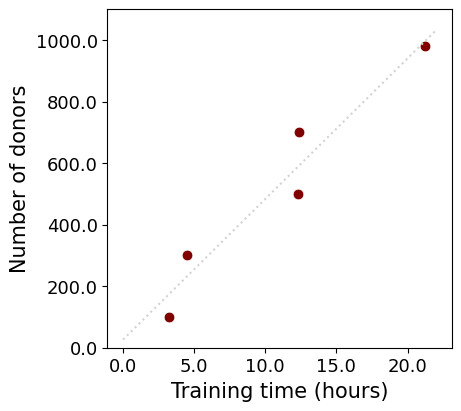

In [84]:
fig, axs = plt.subplots(nrows=1, figsize = (4.5,4), constrained_layout=True)
sns.scatterplot(x=[v for v in rt_hours_donors_plot.values()], y=[k for k in rt_hours_donors_plot.keys()], 
                ax=axs, color="maroon", s=60, rasterized=True)
x = np.arange(axs.get_xticks()[0], axs.get_xticks()[-1])
b, a = np.polyfit(x=[v for v in rt_hours_donors_plot.values()], y=[k for k in rt_hours_donors_plot.keys()], deg=1)
y = a +b *x
axs.plot(x, y, marker="", linestyle=":", color="lightgrey")
axs.set_xticks(np.arange(0, axs.get_xticks()[-1], 5), np.arange(0, axs.get_xticks()[-1], 5), fontsize=13)
axs.set_yticks(np.arange(0, axs.get_yticks()[-1], 200), np.arange(0, axs.get_yticks()[-1], 200), fontsize=13)
axs.set_ylim(0,1100)
axs.set_xlabel("Training time (hours)", fontdict={"fontsize":15})
axs.set_ylabel("Number of donors", fontdict={"fontsize":15})
plt.savefig(os.path.join(figure_dir, "Runtime_N_donors.png"), 
            transparent=True, dpi=300, bbox_inches="tight")
plt.savefig(os.path.join(figure_dir, "Runtime_N_donors.svg"), 
            transparent=True, dpi=300, bbox_inches="tight")

In [132]:
# Augmented data with same number of donors
rt_hours_plot_aug = {k: rt_hours_plot[k] for k in rt_hours_plot.keys() if k > 1e6}
rt_hours_plot_aug

{1172790: 21.242688887582887,
 1500000.0: 19.58609018041028,
 1800000.0: 22.15687061342928,
 2000000.0: 26.569780206878978}

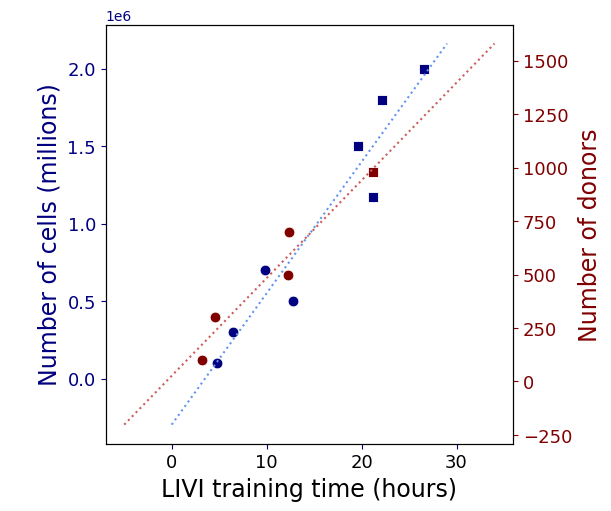

In [138]:
fig, axs = plt.subplots(nrows=1, figsize = (6,5), constrained_layout=True)
sns.scatterplot(x=[v for v in rt_hours_plot.values()], y=[k for k in rt_hours_plot.keys()], ax=axs, color="navy", s=60)
sns.scatterplot(x=[v for v in rt_hours_plot_aug.values()], y=[k for k in rt_hours_plot_aug.keys()], ax=axs, color="navy", s=60, marker="s") 
x = np.arange(axs.get_xticks()[0], axs.get_xticks()[-1])
b, a = np.polyfit(x=[v for v in rt_hours_plot.values()], y=[k for k in rt_hours_plot.keys()], deg=1)
y = a +b *x
axs.plot(x, y, marker="", linestyle=":", color="cornflowerblue")
axs.set_ylabel("\nNumber of cells (millions)", fontdict={"fontsize":17, "color":"navy"})
axs.set_xlabel("LIVI training time (hours)", fontdict={"fontsize":17})
axs.tick_params(axis="x", color="navy", labelcolor="black", labelsize=13)
axs.tick_params(axis="y", color="navy", labelcolor="navy", labelsize=13)

axs2 = axs.twinx() 
sns.scatterplot(x=[v for v in rt_hours_donors_plot.values()], y=[k for k in rt_hours_donors_plot.keys()],
                ax=axs2, color="maroon", s=60)
sns.scatterplot(x=[rt_hours_donors_plot[981]], y=[981], ax=axs2, color="maroon", s=60, marker="s")
x = np.arange(axs.get_xticks()[0], axs.get_xticks()[-1])
b, a = np.polyfit(x=[v for v in rt_hours_donors_plot.values()], y=[k for k in rt_hours_donors_plot.keys()], deg=1)
y = a +b *x
axs2.plot(x, y, marker="", linestyle=":", color="indianred")
axs2.set_ylabel("Number of donors", fontdict={"fontsize":17, "color":"maroon"})
axs2.tick_params(axis="y", color="maroon", labelcolor="maroon", labelsize=13)

plt.savefig(os.path.join(figure_dir, "Runtime_N_cells_N_donors.png"), 
            transparent=True, dpi=300, bbox_inches="tight")
plt.savefig(os.path.join(figure_dir, "Runtime_N_cells_N_donors.svg"), 
            transparent=True, dpi=300, bbox_inches="tight")

## Association Testing

In [95]:
testing_seconds = {}
testing_hours = {}
n_discoveries = {}

for exp in experiments_n_cells:
    n_cells = exp.replace("LIVIcis-cell-state_zdim15_700-gxc_5-persistent_60-0-warm-up_no-adversary_Gseed200_hvg-hex-10K_Gseed200_", "")
    exp_dir = [di for di in os.listdir(testing_dir) if exp in di][0]
    rt = pd.read_csv(os.path.join(testing_dir, exp_dir, "association_testing_execution_time.txt"), sep=" ", header=None)
    testing_seconds[n_cells] = rt[4].iloc[0] # runtime is in the 5th column, 1st row
    testing_hours[n_cells] = rt[4].iloc[2] # # runtime is in the 5th column, 3rd row
    lmm_results = pd.read_csv(os.path.join(testing_dir, exp_dir, f"{exp_dir}_LMM_results_BH-0.05_Ucontext.tsv"), 
                              sep="\t", index_col=False)
    n_discoveries[n_cells] = lmm_results.SNP_id.nunique()

testing_hours

{'2024-12-05_10-20_LIVIcis-cell-state_zdim15_700-gxc_5-persistent_60-0-warm-up_no-adversary_Gseed200_hvg-hex-10K_larger-encoder': 0.5813888888888888,
 '700K-cells': 0.5822222222222222,
 '500K-cells': 0.7769444444444444,
 '300K-cells': 0.5877777777777777,
 '100K-cells': 0.5905555555555555,
 '1.5M-cells': 0.6455555555555555,
 '1.8M-cells': 0.6463888888888889,
 '2M-cells': 0.5950000000000001}

In [92]:
n_discoveries

{'2024-12-05_10-20_LIVIcis-cell-state_zdim15_700-gxc_5-persistent_60-0-warm-up_no-adversary_Gseed200_hvg-hex-10K_larger-encoder': 941,
 '700K-cells': 791,
 '500K-cells': 687,
 '300K-cells': 697,
 '100K-cells': 265,
 '1.5M-cells': 812,
 '1.8M-cells': 847,
 '2M-cells': 849}

In [96]:
testing_hours_plot = {ncells[k]: v for k,v in testing_hours.items()}
testing_hours_plot 

{1172790: 0.5813888888888888,
 700000.0: 0.5822222222222222,
 500000.0: 0.7769444444444444,
 300000.0: 0.5877777777777777,
 100000.0: 0.5905555555555555,
 1500000.0: 0.6455555555555555,
 1800000.0: 0.6463888888888889,
 2000000.0: 0.5950000000000001}

In [165]:
n_discoveries = {ncells[k]: v for k,v in n_discoveries.items()}
n_discoveries

{1172790: 941,
 700000.0: 791,
 500000.0: 687,
 300000.0: 697,
 100000.0: 265,
 1500000.0: 812,
 1800000.0: 847,
 2000000.0: 849}

In [166]:
n_discoveries_plot = {k: n_discoveries[k] for k in n_discoveries.keys() if k not in rt_hours_plot_aug.keys()}
n_discoveries_plot[adata_obs.shape[0]] = n_discoveries[adata_obs.shape[0]]
n_discoveries_plot

{700000.0: 791, 500000.0: 687, 300000.0: 697, 100000.0: 265, 1172790: 941}

In [157]:
testing_hours_plot_aug = {k: testing_hours_plot[k] for k in testing_hours_plot.keys() if k > 1e6} 
testing_hours_plot_aug

{1172790: 0.5813888888888888,
 1500000.0: 0.6455555555555555,
 1800000.0: 0.6463888888888889,
 2000000.0: 0.5950000000000001}

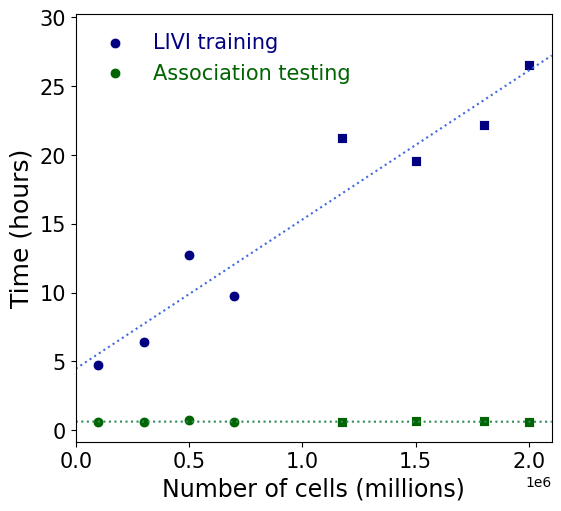

In [207]:
fig, axs = plt.subplots(nrows=1, figsize = (5.5,5), constrained_layout=True)
sns.scatterplot(x=[k for k in rt_hours_plot.keys()], y=[v for v in rt_hours_plot.values()], 
                ax=axs, color="navy", s=60, label="LIVI training", rasterized=True)
sns.scatterplot(x=[k for k in rt_hours_plot_aug.keys()], y=[v for v in rt_hours_plot_aug.values()], 
                ax=axs, color="navy", s=60, rasterized=True, marker="s") 

x = np.arange(axs.get_xticks()[0], axs.get_xticks()[-1])
b, a = np.polyfit(x=[k for k in rt_hours_plot.keys()], y=[v for v in rt_hours_plot.values()], deg=1)
y = a +b *x
axs.plot(x, y, marker="", linestyle=":", color="royalblue")
axs.set_xlabel("Number of cells (millions)", fontdict={"fontsize":17})
axs.set_ylabel("Time (hours)", fontdict={"fontsize":18})
axs.tick_params(axis="both", labelsize=15)

sns.scatterplot(x=[k for k in testing_hours_plot.keys()], y=[v for v in testing_hours_plot.values()],
                ax=axs, color="darkgreen", s=60, label="Association testing", rasterized=True)
sns.scatterplot(x=[k for k in testing_hours_plot_aug.keys()], y=[v for v in testing_hours_plot_aug.values()],
                ax=axs, color="darkgreen", s=60, rasterized=True, marker="s") 

x = np.arange(axs.get_xticks()[0], axs.get_xticks()[-1])
b, a = np.polyfit(x=[k for k in testing_hours_plot.keys()], y=[v for v in testing_hours_plot.values()], deg=1)
y = a +b *x
axs.plot(x, y, marker="", linestyle=":", color="seagreen")
axs.set_xlim(0, 2100000)
#axs.legend(fontsize=14)
for text, color in zip(axs.legend(fontsize=15, frameon=False).get_texts(), ["navy", "darkgreen"]):
    text.set_color(color)

plt.savefig(os.path.join(figure_dir, "Training_Testing_time_N_cells.png"), 
            transparent=True, dpi=300, bbox_inches="tight")
plt.savefig(os.path.join(figure_dir, "Training_Testing_time_N_cells.svg"), 
            transparent=True, dpi=300, bbox_inches="tight")

In [164]:
total_time_plot = {k: rt_hours_plot[k]+testing_hours_plot[k] for k in rt_hours_plot.keys() if k not in rt_hours_plot_aug.keys()}
total_time_plot[adata_obs.shape[0]] = rt_hours_plot[adata_obs.shape[0]] + testing_hours_plot[adata_obs.shape[0]]
total_time_plot

{700000.0: 10.36254419181082,
 500000.0: 13.541732334825728,
 300000.0: 7.00339075949457,
 100000.0: 5.334509736034605,
 1172790: 21.824077776471775}

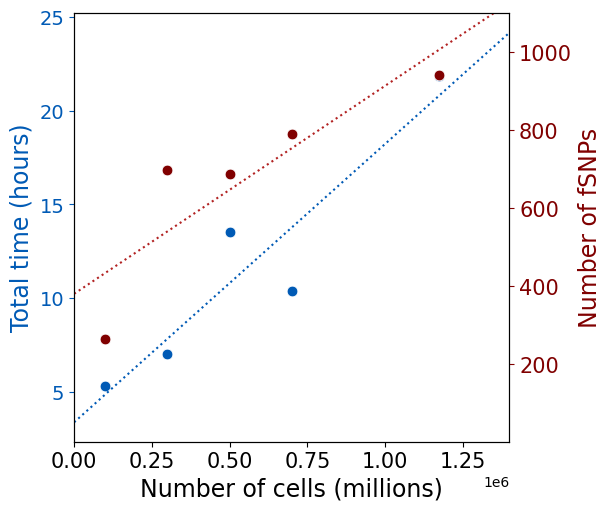

In [208]:
fig, axs = plt.subplots(nrows=1, figsize = (6,5), constrained_layout=True)
sns.scatterplot(x=[k for k in total_time_plot.keys()], y=[v for v in total_time_plot.values()], ax=axs, color="#005AB5", s=60)
x = np.arange(axs.get_xticks()[0], axs.get_xticks()[-1])
b, a = np.polyfit(x=[k for k in total_time_plot.keys()], y=[v for v in total_time_plot.values()], deg=1)
y = a +b *x
axs.plot(x, y, marker="", linestyle=":", color="#005AB5")
axs.set_xlabel("Number of cells (millions)", fontdict={"fontsize":17})
axs.set_ylabel("Total time (hours)", fontdict={"fontsize":17, "color":"#005AB5"})
axs.tick_params(axis="y", color="#005AB5", labelcolor="#005AB5", labelsize=14)
axs.tick_params(axis="x", labelsize=15)
axs.set_xlim(0, 1.4e6)

axs2 = axs.twinx() 
sns.scatterplot(x=[k for k in n_discoveries_plot.keys()], y=[v for v in n_discoveries_plot.values()], ax=axs2, color="maroon", s=60)
x = np.arange(axs2.get_xticks()[0], axs2.get_xticks()[-1])
b, a = np.polyfit(x=[k for k in n_discoveries_plot.keys()], y=[v for v in n_discoveries_plot.values()], deg=1)
y = a +b *x
axs2.plot(x, y, marker="", linestyle=":", color="firebrick")
axs2.set_ylabel("Number of fSNPs", fontdict={"fontsize":17, "color":"maroon"})
axs2.tick_params(axis="y", color="maroon", labelcolor="maroon", labelsize=15)
axs2.set_ylim(1, 1100)

plt.savefig(os.path.join(figure_dir, "Time_NfSNPs_N_cells.png"), 
            transparent=True, dpi=300, bbox_inches="tight")
plt.savefig(os.path.join(figure_dir, "Time_NfSNPs_N_cells.svg"), 
            transparent=True, dpi=300, bbox_inches="tight")

#### Donors

In [139]:
testing_seconds_donors = {}
testing_hours_donors = {}
n_discoveries_donors = {}

for exp in experiments_n_donors:
    n_donors = exp.replace("LIVIcis-cell-state_zdim15_700-gxc_5-persistent_60-0-warm-up_no-adversary_Gseed200_hvg-hex-10K_Gseed200_", "")
    exp_dir = [di for di in os.listdir(testing_dir) if exp in di][0]
    rt = pd.read_csv(os.path.join(testing_dir, exp_dir, "association_testing_execution_time.txt"), sep=" ", header=None)
    testing_seconds_donors[n_donors] = rt[4].iloc[0] # runtime is in the 5th column, 1st row
    testing_hours_donors[n_donors] = rt[4].iloc[2] # # runtime is in the 5th column, 3rd row
    lmm_results = pd.read_csv(os.path.join(testing_dir, exp_dir, f"{exp_dir}_LMM_results_BH-0.05_Ucontext.tsv"), 
                              sep="\t", index_col=False)
    n_discoveries_donors[n_donors] = lmm_results.SNP_id.nunique()

testing_hours_donors

{'2024-12-05_10-20_LIVIcis-cell-state_zdim15_700-gxc_5-persistent_60-0-warm-up_no-adversary_Gseed200_hvg-hex-10K_larger-encoder': 0.5813888888888888,
 '1.5M-cells': 0.6455555555555555,
 '1.8M-cells': 0.6463888888888889,
 '2M-cells': 0.5950000000000001,
 '700-donors': 0.5252777777777777,
 '500-donors': 0.5963888888888889,
 '300-donors': 0.5066666666666666,
 '100-donors': 0.3747222222222222}

In [140]:
n_discoveries_donors

{'2024-12-05_10-20_LIVIcis-cell-state_zdim15_700-gxc_5-persistent_60-0-warm-up_no-adversary_Gseed200_hvg-hex-10K_larger-encoder': 941,
 '1.5M-cells': 812,
 '1.8M-cells': 847,
 '2M-cells': 849,
 '700-donors': 708,
 '500-donors': 607,
 '300-donors': 362,
 '100-donors': 24}

In [144]:
testing_hours_donors_plot = {ndonors[k]: v for k,v in testing_hours_donors.items() if k in ndonors.keys()}
testing_hours_donors_plot 

{981: 0.5813888888888888,
 700: 0.5252777777777777,
 500: 0.5963888888888889,
 300: 0.5066666666666666,
 100: 0.3747222222222222}

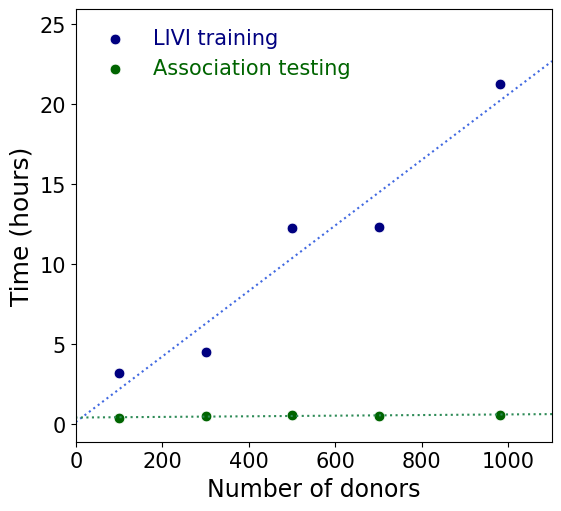

In [200]:
fig, axs = plt.subplots(nrows=1, figsize = (5.5,5), constrained_layout=True)
sns.scatterplot(x=[k for k in rt_hours_donors_plot.keys()], y=[v for v in rt_hours_donors_plot.values()], 
                ax=axs, color="navy", s=60, label="LIVI training", rasterized=True)
x = np.arange(axs.get_xticks()[0], axs.get_xticks()[-1])
b, a = np.polyfit(x=[k for k in rt_hours_donors_plot.keys()], y=[v for v in rt_hours_donors_plot.values()], deg=1)
y = a +b *x
axs.plot(x, y, marker="", linestyle=":", color="royalblue")
axs.set_xlabel("Number of donors", fontdict={"fontsize":17})
axs.set_ylabel("Time (hours)", fontdict={"fontsize":18})
axs.tick_params(axis="both", labelsize=15)

sns.scatterplot(x=[k for k in testing_hours_donors_plot.keys()], y=[v for v in testing_hours_donors_plot.values()],
                ax=axs, color="darkgreen", s=60, label="Association testing", rasterized=True)
x = np.arange(axs.get_xticks()[0], axs.get_xticks()[-1])
b, a = np.polyfit(x=[k for k in testing_hours_donors_plot.keys()], y=[v for v in testing_hours_donors_plot.values()], deg=1)
y = a +b *x
axs.plot(x, y, marker="", linestyle=":", color="seagreen")
axs.set_xlim(0, 1100)
#axs.legend(fontsize=14)
for text, color in zip(axs.legend(fontsize=15, frameon=False).get_texts(), ["navy", "darkgreen"]):
    text.set_color(color)

plt.savefig(os.path.join(figure_dir, "Training_Testing_time_N_donors.png"), 
            transparent=True, dpi=300, bbox_inches="tight")
plt.savefig(os.path.join(figure_dir, "Training_Testing_time_N_donors.svg"), 
            transparent=True, dpi=300, bbox_inches="tight")

In [180]:
total_time_donors_plot = {k: rt_hours_donors_plot[k]+testing_hours_donors_plot[k] for k in rt_hours_donors_plot.keys()}
total_time_donors_plot

{981: 21.824077776471775,
 700: 12.87467492726114,
 500: 12.859669012493557,
 300: 5.016192925241259,
 100: 3.5808882921271854}

In [145]:
n_discoveries_donors_plot = {ndonors[k]: v for k,v in n_discoveries_donors.items() if k in ndonors.keys()}
n_discoveries_donors_plot

{981: 941, 700: 708, 500: 607, 300: 362, 100: 24}

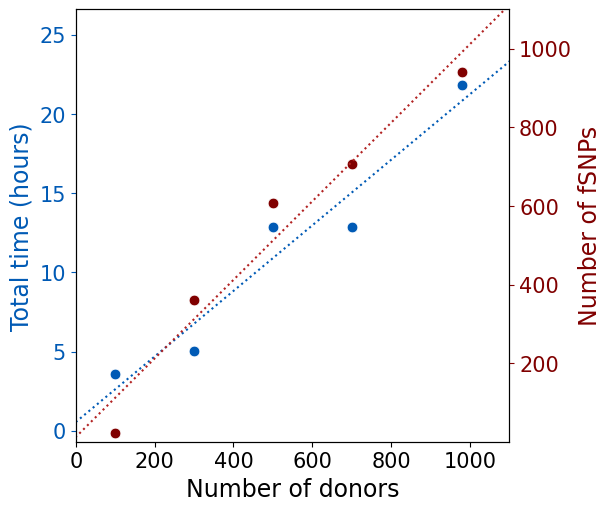

In [199]:
fig, axs = plt.subplots(nrows=1, figsize = (6,5), constrained_layout=True)
sns.scatterplot(x=[k for k in total_time_donors_plot.keys()], y=[v for v in total_time_donors_plot.values()], ax=axs, color="#005AB5", s=60)
x = np.arange(axs.get_xticks()[0], axs.get_xticks()[-1])
b, a = np.polyfit(x=[k for k in total_time_donors_plot.keys()], y=[v for v in total_time_donors_plot.values()], deg=1)
y = a +b *x
axs.plot(x, y, marker="", linestyle=":", color="#005AB5")
axs.set_xlabel("Number of donors", fontdict={"fontsize":17})
axs.set_ylabel("Total time (hours)", fontdict={"fontsize":17, "color":"#005AB5"})
axs.tick_params(axis="y", color="#005AB5", labelcolor="#005AB5", labelsize=15)
axs.tick_params(axis="x", labelsize=15)

axs2 = axs.twinx() 
sns.scatterplot(x=[k for k in n_discoveries_donors_plot.keys()], y=[v for v in n_discoveries_donors_plot.values()], ax=axs2, color="maroon", s=60)
x = np.arange(axs2.get_xticks()[0], axs2.get_xticks()[-1])
b, a = np.polyfit(x=[k for k in n_discoveries_donors_plot.keys()], y=[v for v in n_discoveries_donors_plot.values()], deg=1)
y = a +b *x
axs2.plot(x, y, marker="", linestyle=":", color="firebrick")
axs2.set_ylabel("Number of fSNPs", fontdict={"fontsize":17, "color":"maroon"})
axs2.tick_params(axis="y", color="maroon", labelcolor="maroon", labelsize=15)
axs2.set_ylim(1, 1100)
axs.set_xlim(0, 1100)

plt.savefig(os.path.join(figure_dir, "Time_NfSNPs_N_donors.png"), 
            transparent=True, dpi=300, bbox_inches="tight")
plt.savefig(os.path.join(figure_dir, "Time_NfSNPs_N_donors.svg"), 
            transparent=True, dpi=300, bbox_inches="tight")

#### N GxC factors

In [19]:
rt_seconds_gxc = {}
testing_seconds_gxc = {}
testing_mins_gxc = {}
testing_hours_gxc = {}
n_discoveries_gxc = {}
loss_gxc = {}

for exp in experiments_n_gxc:
    ngxc = re.search("([0-9]{3}-gxc)", exp).groups()[0].replace("-gxc", "")
    logs_exp = [di for di in os.listdir(ckpt_dir) if exp.replace("_best", "") in di][0]
    rt = pd.read_csv(os.path.join(ckpt_dir, logs_exp, "exec_time.log"), sep=" ", header=None)
    rt = list(rt[3])[0] # runtime is in the 4th column
    rt_seconds_gxc[int(ngxc)] = rt
    best_ckpt = [f for f in os.listdir(os.path.join(ckpt_dir, logs_exp, "checkpoints")) if "hp_metric" in f][0]
    loss = re.search(".*hp_metric=([0-9]+.[0-9]+).ckpt", best_ckpt).groups()[0]
    loss_gxc[int(ngxc)] = loss
    test_exp = [di for di in os.listdir(testing_dir) if exp in di][0]
    rt = pd.read_csv(os.path.join(testing_dir, test_exp, "association_testing_execution_time.txt"), sep=" ", header=None)
    testing_seconds_gxc[int(ngxc)] = rt[4].iloc[0] # runtime sec is in the 5th column, 1st row
    testing_mins_gxc[int(ngxc)] = rt[4].iloc[1] # runtime mins is in the 5th column, 2nd row
    testing_hours_gxc[int(ngxc)] = rt[4].iloc[2] # runtime hrs is in the 5th column, 3rd row
    lmm_results = pd.read_csv(os.path.join(testing_dir, test_exp, f"{test_exp}_LMM_results_BH-0.05_Ucontext.tsv"), 
                              sep="\t", index_col=False)
    n_discoveries_gxc[int(ngxc)] = lmm_results.SNP_id.nunique()

rt_mins_gxc = {k:v/60 for k,v in rt_seconds_gxc.items()}
rt_hours_gxc = {k:v/3600 for k,v in rt_seconds_gxc.items()}
rt_hours_gxc

{700: 21.242688887582887,
 900: 21.283835646708805,
 500: 23.284887598488066,
 300: 21.23726344777478,
 100: 21.443867192731965}

In [20]:
testing_hours_gxc

{700: 0.0352777777777777,
 900: 1.0786111111111112,
 500: 0.2994444444444444,
 300: 0.0152777777777777,
 100: 0.0058333333333333}

In [21]:
n_discoveries_gxc

{700: 941, 900: 807, 500: 734, 300: 693, 100: 501}

In [23]:
loss_gxc

{700: '2857.55347',
 900: '2857.64380',
 500: '2856.87671',
 300: '2856.63794',
 100: '2856.31030'}

In [13]:
rt_mins_gxc

{700: 1274.561333254973,
 900: 1277.0301388025284,
 500: 1397.093255909284,
 300: 1274.2358068664869,
 100: 1286.6320315639177}

In [14]:
testing_mins_gxc

{700: 2.1166666666666667,
 900: 64.71666666666667,
 500: 17.966666666666665,
 300: 0.9166666666666666,
 100: 0.35}

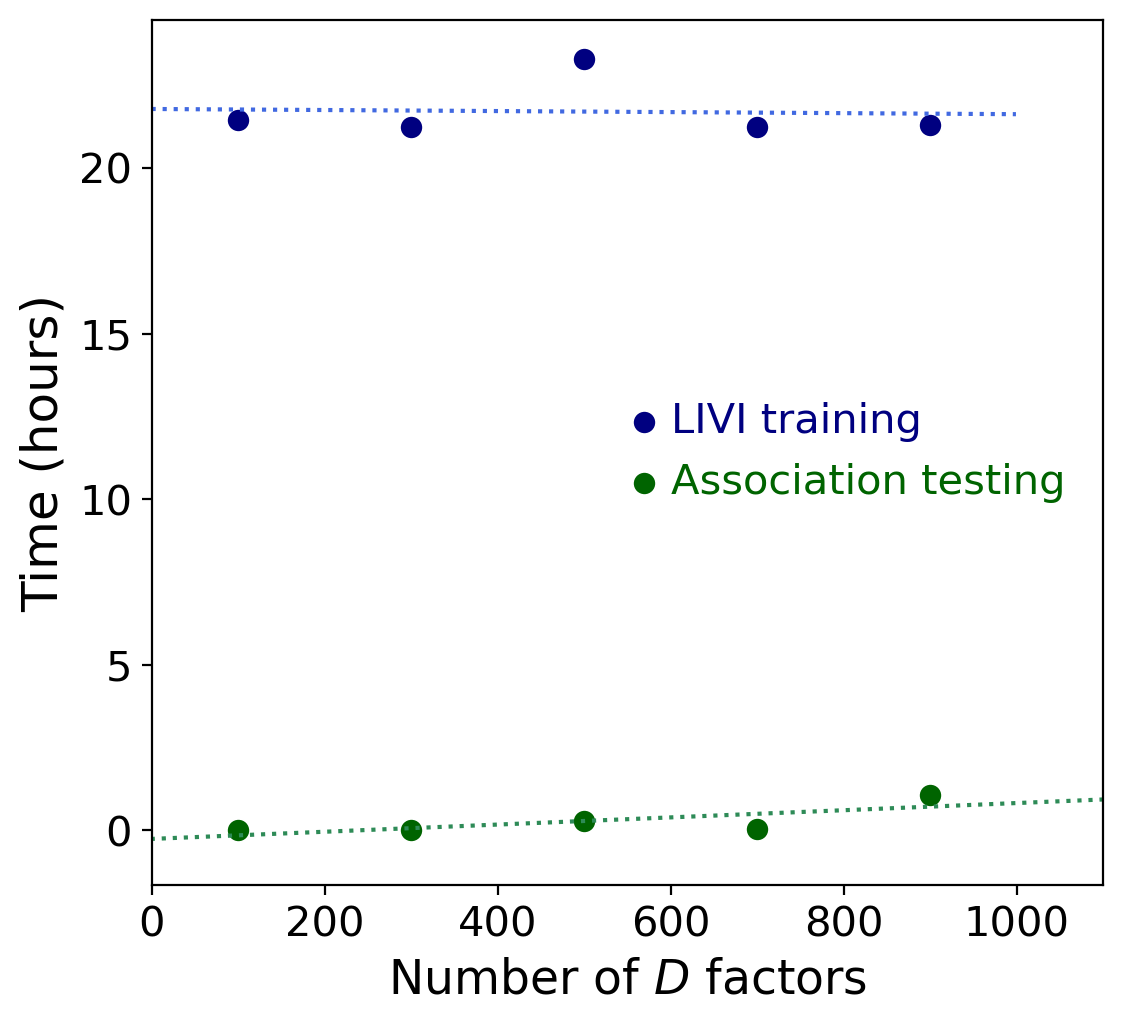

In [15]:
fig, axs = plt.subplots(nrows=1, figsize = (5.5,5), constrained_layout=True)
sns.scatterplot(x=[k for k in rt_hours_gxc.keys()], y=[v for v in rt_hours_gxc.values()], 
                ax=axs, color="navy", s=70, label="LIVI training", rasterized=True)
x = np.arange(axs.get_xticks()[0], axs.get_xticks()[-1])
b, a = np.polyfit(x=[k for k in rt_hours_gxc.keys()], y=[v for v in rt_hours_gxc.values()], deg=1)
y = a +b *x
axs.plot(x, y, marker="", linestyle=":", color="royalblue")
axs.set_xlabel("Number of $D$ factors", fontdict={"fontsize":17})
axs.set_ylabel("Time (hours)", fontdict={"fontsize":18})
axs.tick_params(axis="both", labelsize=15)

sns.scatterplot(x=[k for k in testing_hours_gxc.keys()], y=[v for v in testing_hours_gxc.values()],
                ax=axs, color="darkgreen", s=70, label="Association testing", rasterized=True)
x = np.arange(axs.get_xticks()[0], axs.get_xticks()[-1])
b, a = np.polyfit(x=[k for k in testing_hours_gxc.keys()], y=[v for v in testing_hours_gxc.values()], deg=1)
y = a +b *x
axs.plot(x, y, marker="", linestyle=":", color="seagreen")
axs.set_xlim(0, 1100)
#axs.legend(fontsize=14)
for text, color in zip(axs.legend(fontsize=15, frameon=False).get_texts(), ["navy", "darkgreen"]):
    text.set_color(color)

plt.savefig(os.path.join(figure_dir, "Training_Testing_time_N_DxC.png"), 
            transparent=True, dpi=300, bbox_inches="tight")
plt.savefig(os.path.join(figure_dir, "Training_Testing_time_N_DxC.pdf"), 
            transparent=True, dpi=300, bbox_inches="tight")

In [17]:
total_time_gxc = {k: rt_hours_gxc[k]+testing_hours_gxc[k] for k in rt_hours_gxc.keys()}
total_time_gxc

{700: 21.277966665360665,
 900: 22.362446757819917,
 500: 23.58433204293251,
 300: 21.25254122555256,
 100: 21.449700526065296}

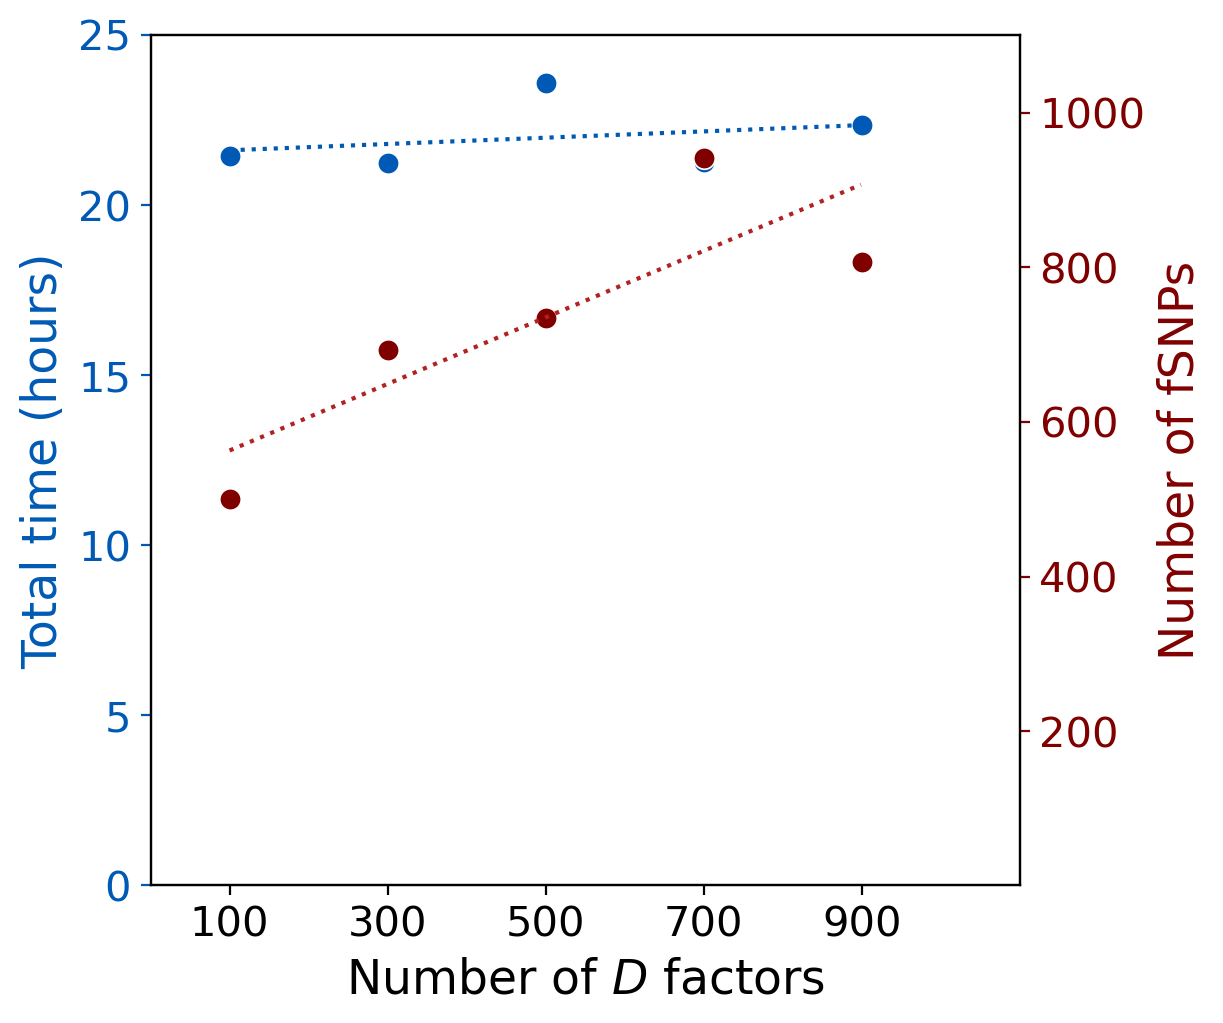

In [18]:
fig, axs = plt.subplots(nrows=1, figsize = (6,5), constrained_layout=True)
sns.scatterplot(x=[k for k in total_time_gxc.keys()], y=[v for v in total_time_gxc.values()], ax=axs, color="#005AB5", s=60)
axs.set_ylim(0,25)
axs.set_xticks(np.arange(100, 1100, 200), np.arange(100, 1100, 200))
x = np.arange(axs.get_xticks()[0], axs.get_xticks()[-1])
b, a = np.polyfit(x=[k for k in total_time_gxc.keys()], y=[v for v in total_time_gxc.values()], deg=1)
y = a +b *x
axs.plot(x, y, marker="", linestyle=":", color="#005AB5")
axs.set_xlabel("Number of $D$ factors", fontdict={"fontsize":17})
axs.set_ylabel("Total time (hours)", fontdict={"fontsize":17, "color":"#005AB5"})
axs.tick_params(axis="y", color="#005AB5", labelcolor="#005AB5", labelsize=15)
axs.tick_params(axis="x", labelsize=15)

axs2 = axs.twinx() 
sns.scatterplot(x=[k for k in n_discoveries_gxc.keys()], y=[v for v in n_discoveries_gxc.values()], ax=axs2, color="maroon", s=60)
x = np.arange(axs2.get_xticks()[0], axs2.get_xticks()[-1])
b, a = np.polyfit(x=[k for k in n_discoveries_gxc.keys()], y=[v for v in n_discoveries_gxc.values()], deg=1)
y = a +b *x
axs2.plot(x, y, marker="", linestyle=":", color="firebrick")
axs2.set_ylabel("Number of fSNPs", fontdict={"fontsize":17, "color":"maroon"})
axs2.tick_params(axis="y", color="maroon", labelcolor="maroon", labelsize=15)
axs2.set_ylim(1, 1100)
axs.set_xlim(0, 1100)

plt.savefig(os.path.join(figure_dir, "Time_NfSNPs_N_DxC.png"), 
            transparent=True, dpi=300, bbox_inches="tight")
plt.savefig(os.path.join(figure_dir, "Time_NfSNPs_N_DxC.pdf"), 
            transparent=True, dpi=300, bbox_inches="tight")